In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
supply_data= pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')
supply_data['Date'] = pd.to_datetime(supply_data['Date'])
supply_data = supply_data.sort_values('Date')
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)
supply_data.set_index('Date', inplace=True)  # Set as index

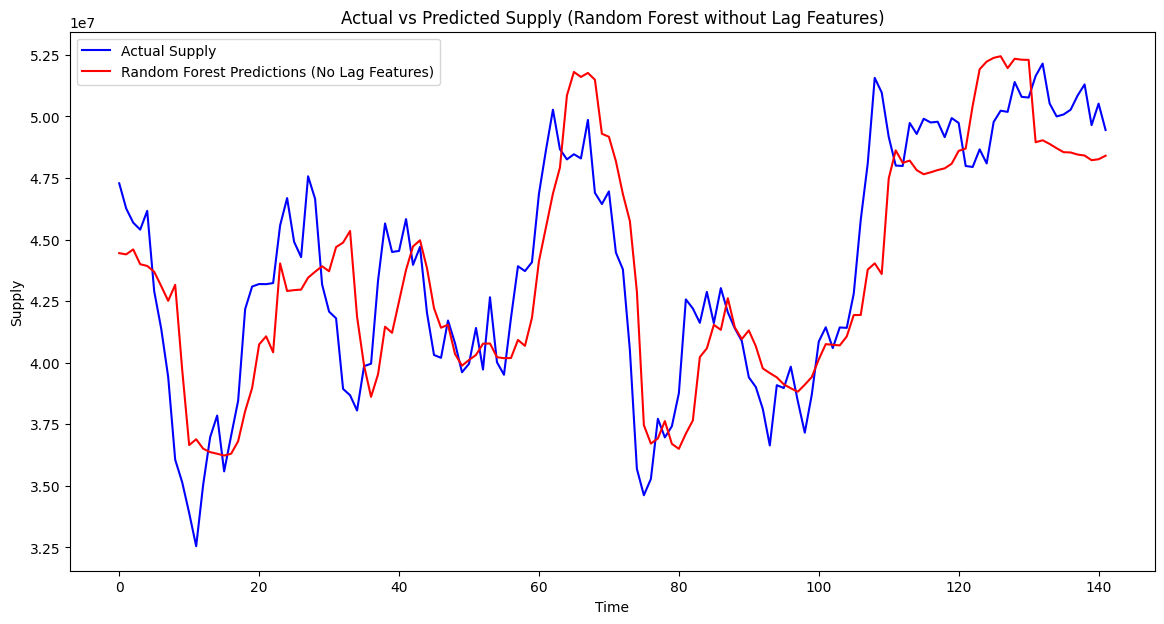

(np.float64(2148436.6743444377), np.float64(2676088.6693586297))

In [4]:
# Feature Engineering
# Create calendar features
supply_data['day'] = supply_data.index.day
supply_data['month'] = supply_data.index.month
supply_data['year'] = supply_data.index.year
supply_data['day_of_week'] = supply_data.index.dayofweek
supply_data['week_of_year'] = supply_data.index.isocalendar().week

# Add rolling statistics as features
supply_data['rolling_mean_7'] = supply_data['Supply'].rolling(window=7).mean()  # 7-day rolling mean
supply_data['rolling_std_7'] = supply_data['Supply'].rolling(window=7).std()    # 7-day rolling std
supply_data['rolling_mean_30'] = supply_data['Supply'].rolling(window=30).mean()  # 30-day rolling mean
supply_data['rolling_std_30'] = supply_data['Supply'].rolling(window=30).std()    # 30-day rolling std

# Drop rows with NaN values resulting from rolling statistics
supply_data.dropna(inplace=True)

# Train-Test Split
train_size = int(len(supply_data) * 0.8)
train_data = supply_data.iloc[:train_size]
test_data = supply_data.iloc[train_size:]

X_train_no_lag = train_data.drop(columns=['Supply'])
y_train = train_data['Supply']
X_test_no_lag = test_data.drop(columns=['Supply'])
y_test = test_data['Supply']

# Train Random Forest on the dataset without lagged features
rf_no_lag_model = RandomForestRegressor(
    n_estimators=200,  # Number of trees
    max_depth=15,      # Larger tree depth for more complexity
    random_state=42,   # Ensuring reproducibility
    min_samples_split=5,  # Minimum samples required to split a node
    min_samples_leaf=2    # Minimum samples required at a leaf node
)
rf_no_lag_model.fit(X_train_no_lag, y_train)

# Predict supply with the new Random Forest model
rf_no_lag_predictions = rf_no_lag_model.predict(X_test_no_lag)

# Evaluate the Random Forest Model without lagged features
mae_rf_no_lag = mean_absolute_error(y_test, rf_no_lag_predictions)
rmse_rf_no_lag = np.sqrt(mean_squared_error(y_test, rf_no_lag_predictions))

# Plot Actual vs Predicted with Random Forest model (No Lag Features)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Supply', color='blue')
plt.plot(rf_no_lag_predictions, label='Random Forest Predictions (No Lag Features)', color='red')
plt.title('Actual vs Predicted Supply (Random Forest without Lag Features)')
plt.xlabel('Time')
plt.ylabel('Supply')
plt.legend()
plt.show()

# Print Error Metrics
mae_rf_no_lag, rmse_rf_no_lag

In [7]:
# Ensure consistent features by excluding unnecessary ones
consistent_features = ['day', 'month', 'year', 'day_of_week', 'week_of_year', 
                       'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'rolling_std_30']

X_train_consistent = X_train_no_lag[consistent_features]
X_test_consistent = X_test_no_lag[consistent_features]

# Retrain the Random Forest model
rf_consistent_model = RandomForestRegressor(
    n_estimators=200,  # Number of trees
    max_depth=15,      # Larger tree depth for more complexity
    random_state=42,   # Ensuring reproducibility
    min_samples_split=5,  # Minimum samples required to split a node
    min_samples_leaf=2    # Minimum samples required at a leaf node
)
rf_consistent_model.fit(X_train_consistent, y_train)

# Prepare future data with consistent features
future_data_consistent = future_data[consistent_features]

# Predict future supply
future_predictions_consistent = rf_consistent_model.predict(future_data_consistent)

# Combine future dates with predictions
future_forecast_consistent = pd.DataFrame({'Date': future_dates, 'Predicted Supply': future_predictions_consistent})

# Display the predictions
future_forecast_consistent.reset_index(drop=True, inplace=True)
future_forecast_consistent.tail(10)  # Display the last 10 days of predictions


,Date,Predicted Supply
20,2024-06-05,4.754400e+07
21,2024-06-06,4.746024e+07
22,2024-06-07,4.739521e+07
23,2024-06-08,4.738164e+07
24,2024-06-09,4.737492e+07
25,2024-06-10,4.744473e+07
26,2024-06-11,4.746698e+07
27,2024-06-12,4.735398e+07
28,2024-06-13,4.730756e+07
29,2024-06-14,4.729193e+07


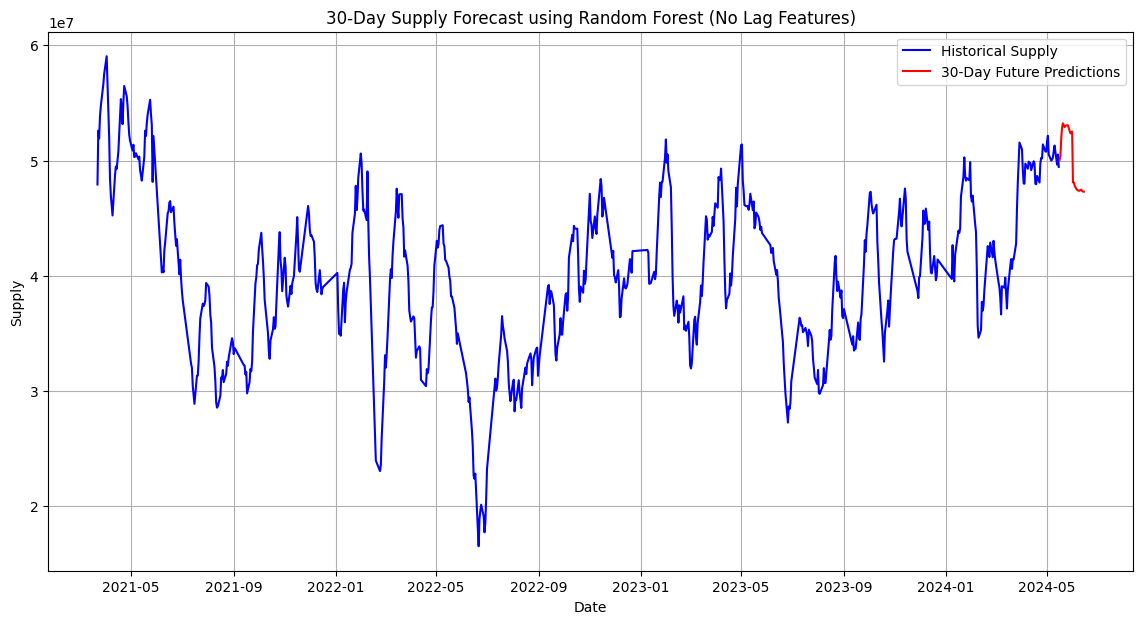

In [8]:

# Plot the 30-day future predictions
plt.figure(figsize=(14, 7))
plt.plot(supply_data['Supply'], label='Historical Supply', color='blue')
plt.plot(future_forecast_consistent['Date'], future_forecast_consistent['Predicted Supply'], 
         label='30-Day Future Predictions', color='red')
plt.title('30-Day Supply Forecast using Random Forest (No Lag Features)')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.legend()
plt.grid(True)
plt.show()